# w261 Final Project - Clickthrough Rate Prediction


# Team & Members

Team #21

Brent Biseda  
Katie Mo  
Teddy Fong  
Thanh Le  
Summer 2019, section 4   

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import sys
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, MinMaxScaler, MaxAbsScaler, Imputer, VectorAssembler, SQLTransformer
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

pd.set_option('display.max_columns', 40)
%matplotlib inline  

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()

In [5]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [6]:
spark

In [7]:
sc._conf.getAll()

[('spark.driver.port', '38259'),
 ('spark.app.name', 'final_project_notebook'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.app.id', 'local-1575523526234'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', 'docker.w261')]

In [8]:
trainDF = sqlContext.read.parquet('train.parquet')

In [9]:
testDF = sqlContext.read.parquet('test.parquet')

In [10]:
# Generate 80/20 (pseudo)random train/test split 
start = time.time()
trainDF, validDF = trainDF.randomSplit([0.8,0.2], seed = 1)
print(f"Assigned {trainDF.count()} for training. Assigned {validDF.count()} for Validation.")
print(f"\n... Executed in {time.time() - start} seconds")

Assigned 36668287 for training. Assigned 9172330 for Validation.

... Executed in 310.782103061676 seconds


In [11]:
HEADER = trainDF.columns
INTEGER_FEATURES = HEADER[0:14] # These are the integer features
CATEGORICAL_FEATURES = HEADER[14:] # These are the categorical features

# Preprocessing

In [12]:
trainDF.take(1)

[Row(y=0.0, x1=None, x2=-2.0, x3=None, x4=None, x5=2890.0, x6=None, x7=0.0, x8=9.0, x9=16.0, x10=None, x11=0.0, x12=None, x13=None, x14='8cf07265', x15='f6f4fe4b', x16='680f077d', x17='e9cac79c', x18='25c83c98', x19='fe6b92e5', x20='2e0b99f0', x21='0b153874', x22='a73ee510', x23='fa6a0a1b', x24='6b5f6a88', x25='7fbb6d63', x26='1399de53', x27='07d13a8f', x28='ef6fe5a5', x29='b8beb278', x30='1e88c74f', x31='0a20b09c', x32='', x33='', x34='042304c2', x35='', x36='32c7478e', x37='59c12dda', x38='', x39='')]

In [13]:
#find number of examples in each class and in total
train_count = trainDF.count()

trainDF_0 = trainDF.where(F.col("y") == 0)
train_count_0 = trainDF_0.count()

trainDF_1 = trainDF.where(F.col("y") == 1)
train_count_1 = trainDF_1.count()

print("There are {} examples in the training set in total, with {} ({:0.2f}%) in class 0 and {} ({:0.2f}%) in class 1." \
      .format(train_count, train_count_0, (train_count_0/train_count)*100, train_count_1, (train_count_1/train_count)*100))

There are 36668287 examples in the training set in total, with 27272663 (74.38%) in class 0 and 9395624 (25.62%) in class 1.


### Integer Columns

In [ ]:
int_summary = trainDF.select(INTEGER_FEATURES).describe().toPandas()
int_summary.set_index("summary", inplace=True, drop=True)
int_summary.T

In [14]:
def imputeValues(df, dfvalid, dftest):

    for col in INTEGER_FEATURES[1:]:
        mean = df.select(col).agg({col:'mean'}).collect()[0][0]
        print(f"Column {col} has mean {mean}")
        
        #impute
        df = df.withColumn(col, F.when(df[col].isNull(), mean).otherwise(df[col]))
        dfvalid = dfvalid.withColumn(col, F.when(dfvalid[col].isNull(), mean).otherwise(dfvalid[col]))
        dftest = dftest.withColumn(col, F.when(dftest[col].isNull(), mean).otherwise(dftest[col]))
        
        #log transform all features except x10
        if col != "x10":
            df = df.withColumn(col, (F.signum(df[col]) * F.log(F.abs(df[col])+0.001)))
            dfvalid = dfvalid.withColumn(col, F.signum(dfvalid[col]) * F.log(F.abs(dfvalid[col])+0.001))
            dftest = dftest.withColumn(col, F.signum(dftest[col]) * F.log(F.abs(dftest[col])+0.001))
            
    return (df, dfvalid, dftest)

In [15]:
start = time.time()
trainDF, validDF, testDF = imputeValues(trainDF, validDF, testDF)
print(f"\n... Executed in {time.time() - start} seconds")

Column x1 has mean 3.5035164323867454
Column x2 has mean 105.82569368457273
Column x3 has mean 26.971816305998836
Column x4 has mean 7.322993362043031
Column x5 has mean 18540.561510691645
Column x6 has mean 116.0490387715087
Column x7 has mean 16.337554503446114
Column x8 has mean 12.51693177473035
Column x9 has mean 106.11499145355863
Column x10 has mean 0.6174881225417977
Column x11 has mean 2.732957913607912
Column x12 has mean 0.9909981944623059
Column x13 has mean 8.217945325296103

... Executed in 1894.8671078681946 seconds


In [16]:
trainDF.take(1)

[Row(y=0.0, x1=1.254052545886255, x2=-0.6936470556015963, x3=3.294829555355739, x4=1.991155720482393, x5=7.969012127127179, x6=4.754021466813529, x7=-0.0, x8=2.1973356822749484, x9=2.7726512202867375, x10=0.6174881225417977, x11=-0.0, x12=-0.008033991797402636, x13=2.1064418949111308, x14='8cf07265', x15='f6f4fe4b', x16='680f077d', x17='e9cac79c', x18='25c83c98', x19='fe6b92e5', x20='2e0b99f0', x21='0b153874', x22='a73ee510', x23='fa6a0a1b', x24='6b5f6a88', x25='7fbb6d63', x26='1399de53', x27='07d13a8f', x28='ef6fe5a5', x29='b8beb278', x30='1e88c74f', x31='0a20b09c', x32='', x33='', x34='042304c2', x35='', x36='32c7478e', x37='59c12dda', x38='', x39='')]

### Categorical Columns

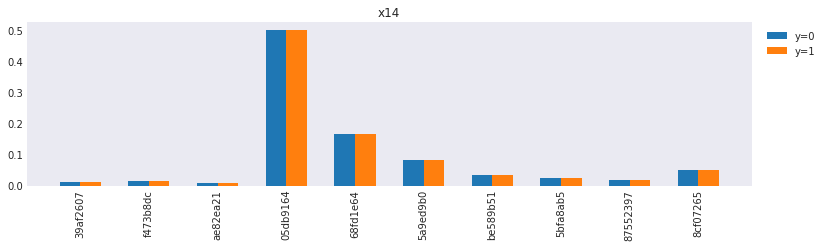

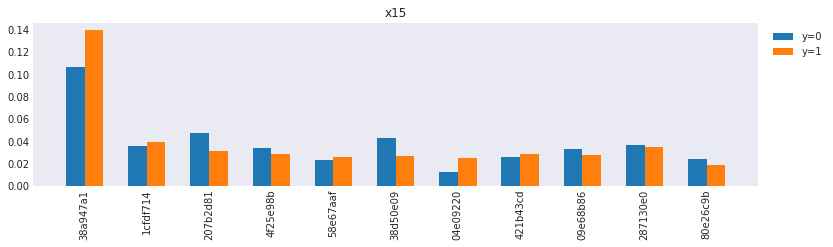

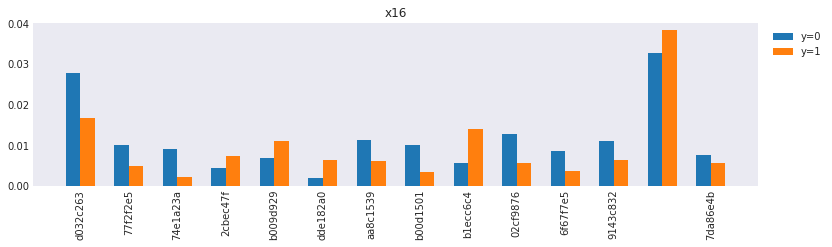

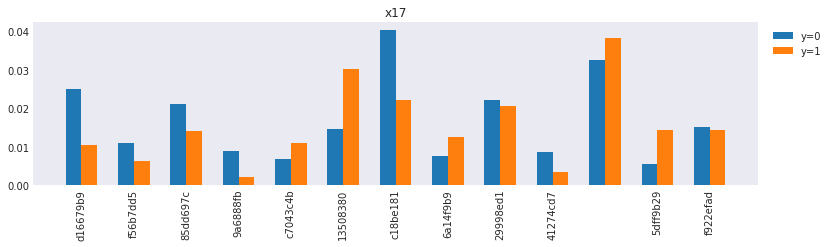

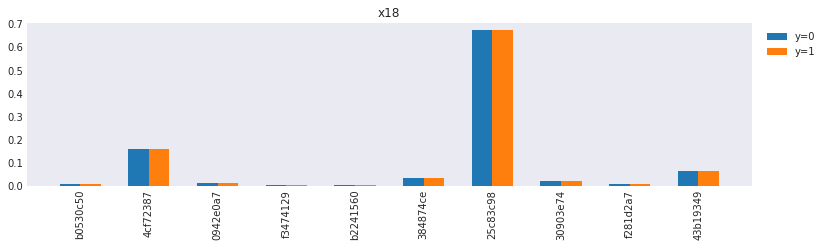

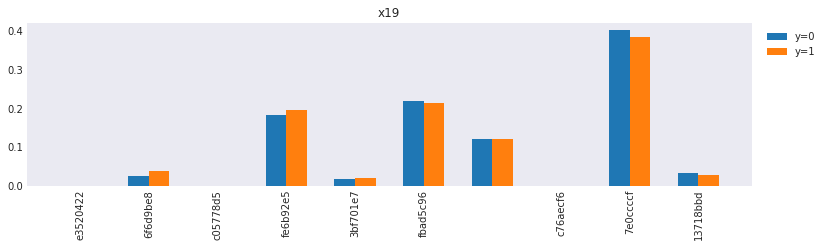

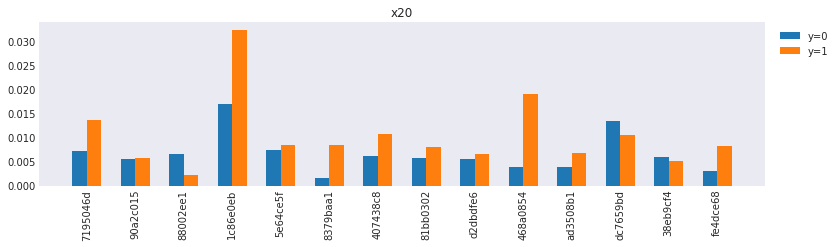

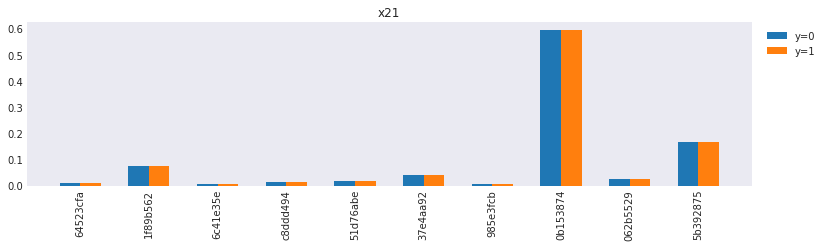

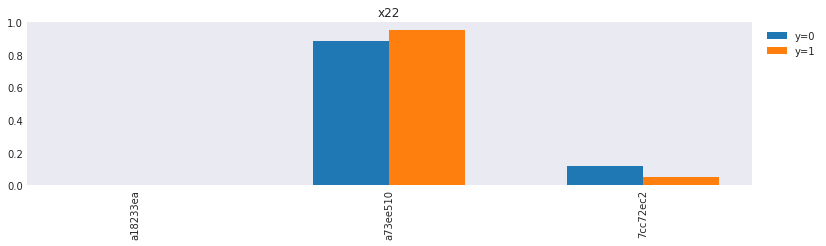

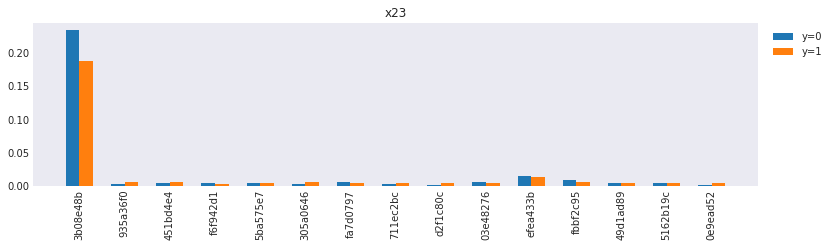

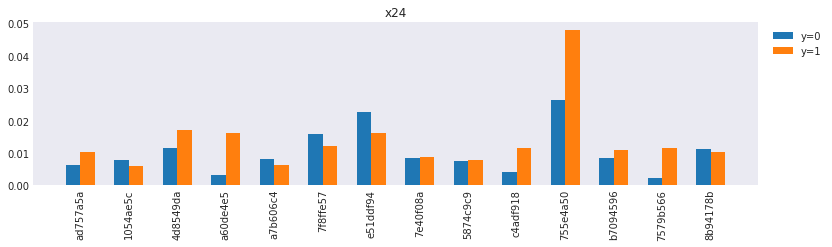

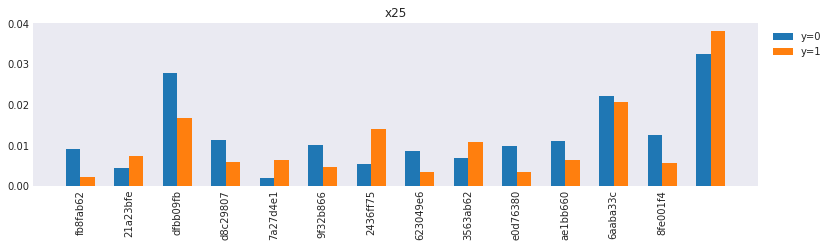

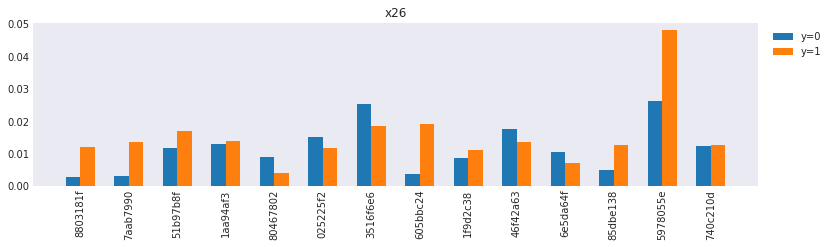

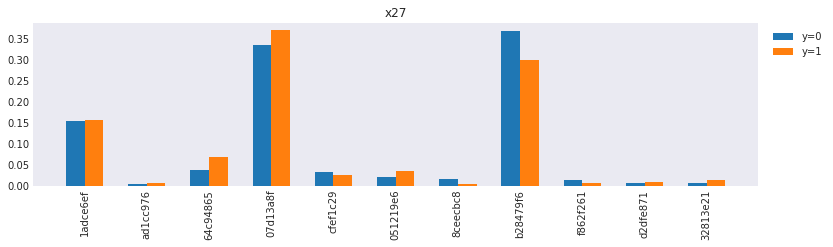

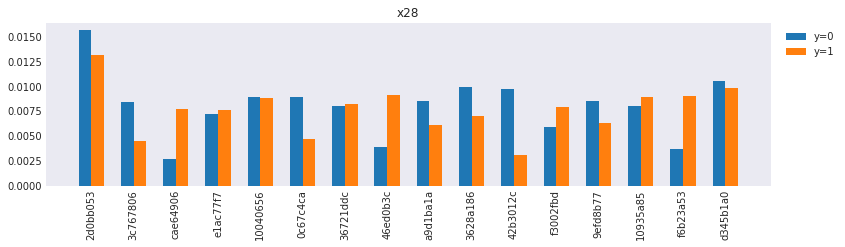

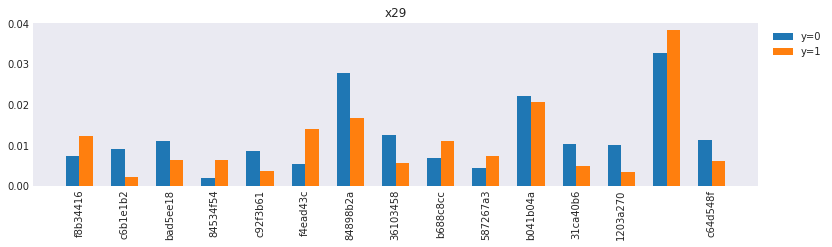

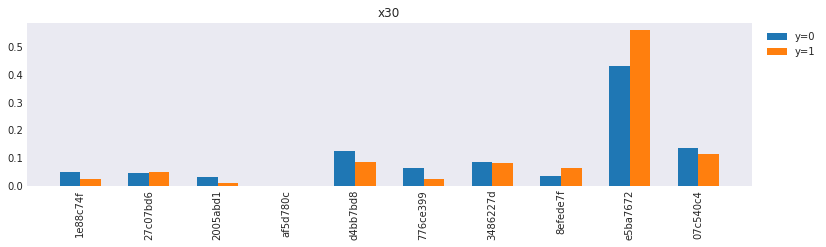

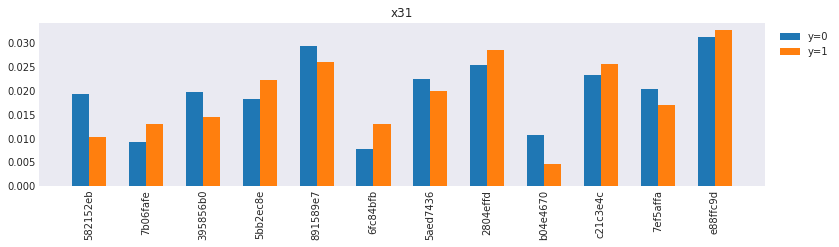

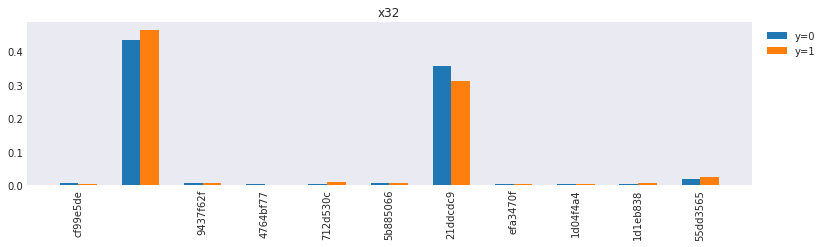

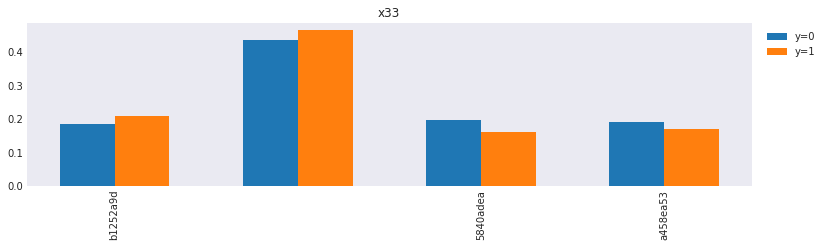

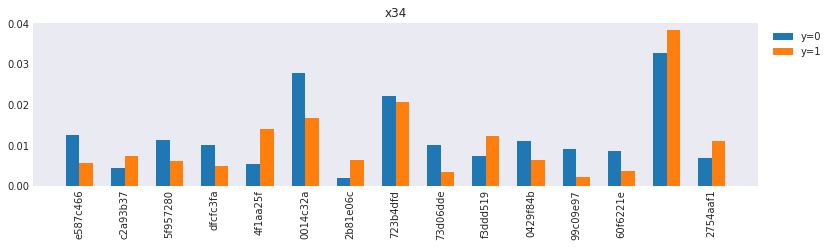

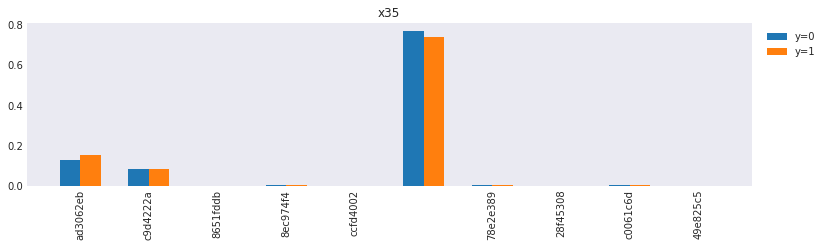

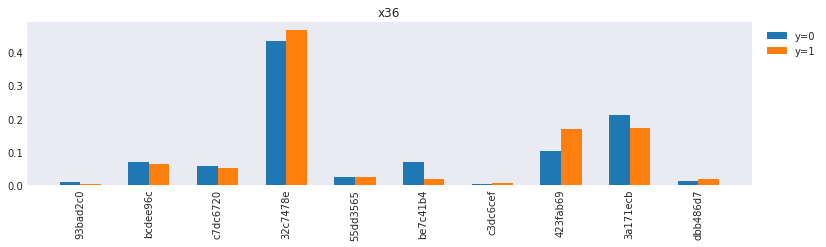

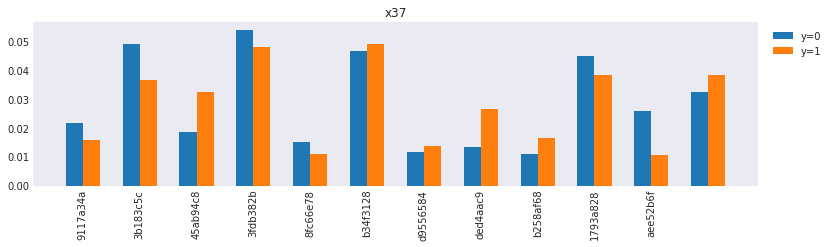

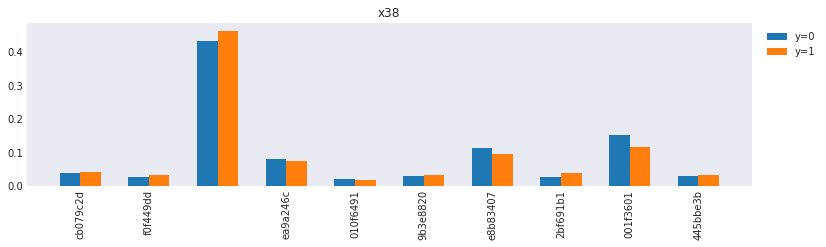

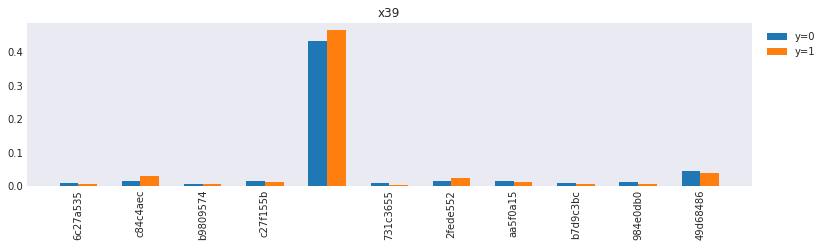


... Executed in 7812.916682004929 seconds


In [17]:
#PYSPARK VERSION - UPDATED

start = time.time()

top_all = pd.DataFrame()

for feature in CATEGORICAL_FEATURES:

    #find the feature's value frequencies for class 0
    values_0_list = trainDF_0.groupBy(feature).agg({"*": "count"})
    values_0_rdd = values_0_list.rdd.map(lambda x: (x[0], (x[1], 0)))

    #find the feature's value frequencies for class 1
    values_1_list = trainDF_1.groupBy(feature).agg({"*": "count"})
    values_1_rdd = values_1_list.rdd.map(lambda x: (x[0], (0, x[1])))

    #concatenate the class 0 and class 1 value frequencies
    all_values = sc.union([values_0_rdd, values_1_rdd]).reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))
    all_values = all_values.map(lambda x: (x[0], x[1][0], x[1][1]))

    #find the top 10 features for each class
    top_0 = all_values.takeOrdered(10, lambda x: -x[1])
    top_1 = all_values.takeOrdered(10, lambda x: -x[2])
    top_both = pd.DataFrame(list(set(top_0)|set(top_1)))
    top_both.set_index(0, inplace=True)
    top_both.columns = ["y=0","y=1"]
    top_both["y=0"] = top_both["y=0"]/train_count_0
    top_both["y=1"] = top_both["y=1"]/train_count_1
    top_both["difference"] = np.abs(top_both["y=0"]-top_both["y=1"])
    top_both["feature"] = feature
    top_all = pd.concat([top_all,top_both],axis=0)

    #create a grouped barplot
    bar_width = 0.3
    bar_loc = np.arange(len(top_both.index))+1
    fig, ax = plt.subplots(figsize=(13, 3))
    plt.bar(bar_loc, top_both["y=0"].values, label="y=0", width=bar_width)
    plt.bar(bar_loc+bar_width, top_both["y=1"].values, label="y=1", width=bar_width)
    ax.set_xticks(bar_loc + bar_width / 2)
    ax.set_xticklabels(top_both.index)
    ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1))
    plt.xticks(rotation=90)
    plt.title(feature)
    plt.show()
    
print(f"\n... Executed in {time.time() - start} seconds")

In [18]:
#filter for the feature values that are present in 1% of samples for either class
#and have at least 0.5% difference between the classes
top_include = top_all[((top_all["y=0"]>0.01)|(top_all["y=1"]>0.01))&(top_all["difference"]>0.005)]
top_include.to_csv("top_include.csv")

In [19]:
top_include = pd.read_csv("top_include.csv", na_filter=False)
top_include.set_index("0", inplace=True, drop=True)
top_include

,y=0,y=1,difference,feature
0,,,,
38a947a1,0.105975,0.138995,0.033020,x15
207b2d81,0.047301,0.031091,0.016210,x15
4f25e98b,0.033802,0.028625,0.005177,x15
38d50e09,0.042466,0.026115,0.016352,x15
04e09220,0.012016,0.024570,0.012555,x15
09e68b86,0.032943,0.027556,0.005387,x15
80e26c9b,0.024032,0.018462,0.005570,x15
d032c263,0.027788,0.016616,0.011172,x16
77f2f2e5,0.010020,0.004749,0.005271,x16


In [20]:
cat_feat_include = list(top_include["feature"].unique())
cat_feat_include

['x15',
 'x16',
 'x17',
 'x19',
 'x20',
 'x22',
 'x23',
 'x24',
 'x25',
 'x26',
 'x27',
 'x29',
 'x30',
 'x31',
 'x32',
 'x33',
 'x34',
 'x35',
 'x36',
 'x37',
 'x38',
 'x39']

In [21]:
def combineValues(df):
    for col in cat_feat_include:
        values_keep = set(top_include[top_include["feature"]==col].index)
        df = df.withColumn(col, F.when(df[col].isin(values_keep), df[col]).otherwise("OTHER"))
    return (df)

In [22]:
start = time.time()
trainDF = combineValues(trainDF)
validDF = combineValues(validDF)
testDF = combineValues(testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 2.356790065765381 seconds


In [23]:
trainDF.take(1)

[Row(y=0.0, x1=1.254052545886255, x2=-0.6936470556015963, x3=3.294829555355739, x4=1.991155720482393, x5=7.969012127127179, x6=4.754021466813529, x7=-0.0, x8=2.1973356822749484, x9=2.7726512202867375, x10=0.6174881225417977, x11=-0.0, x12=-0.008033991797402636, x13=2.1064418949111308, x14='8cf07265', x15='OTHER', x16='OTHER', x17='OTHER', x18='25c83c98', x19='fe6b92e5', x20='OTHER', x21='0b153874', x22='a73ee510', x23='OTHER', x24='OTHER', x25='OTHER', x26='OTHER', x27='07d13a8f', x28='ef6fe5a5', x29='OTHER', x30='1e88c74f', x31='OTHER', x32='', x33='', x34='OTHER', x35='', x36='32c7478e', x37='OTHER', x38='', x39='')]

In [24]:
def emptyValues(df):
    for col in cat_feat_include:
        df = df.withColumn(col, F.when(df[col] == '', "EMPTY").otherwise(df[col]))
    return (df)

In [25]:
start = time.time()
trainDF = emptyValues(trainDF)
validDF = emptyValues(validDF)
testDF = emptyValues(testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.7144801616668701 seconds


In [26]:
trainDF.take(1)

[Row(y=0.0, x1=1.254052545886255, x2=-0.6936470556015963, x3=3.294829555355739, x4=1.991155720482393, x5=7.969012127127179, x6=4.754021466813529, x7=-0.0, x8=2.1973356822749484, x9=2.7726512202867375, x10=0.6174881225417977, x11=-0.0, x12=-0.008033991797402636, x13=2.1064418949111308, x14='8cf07265', x15='OTHER', x16='OTHER', x17='OTHER', x18='25c83c98', x19='fe6b92e5', x20='OTHER', x21='0b153874', x22='a73ee510', x23='OTHER', x24='OTHER', x25='OTHER', x26='OTHER', x27='07d13a8f', x28='ef6fe5a5', x29='OTHER', x30='1e88c74f', x31='OTHER', x32='EMPTY', x33='EMPTY', x34='OTHER', x35='EMPTY', x36='32c7478e', x37='OTHER', x38='EMPTY', x39='EMPTY')]

In [27]:
start = time.time()

assembler = VectorAssembler(inputCols = INTEGER_FEATURES[1:], outputCol = 'integerFeatures')
trainDF = assembler.transform(trainDF)
validDF = assembler.transform(validDF)
testDF = assembler.transform(testDF)

print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.3428647518157959 seconds


In [28]:
trainDF.take(1)

[Row(y=0.0, x1=1.254052545886255, x2=-0.6936470556015963, x3=3.294829555355739, x4=1.991155720482393, x5=7.969012127127179, x6=4.754021466813529, x7=-0.0, x8=2.1973356822749484, x9=2.7726512202867375, x10=0.6174881225417977, x11=-0.0, x12=-0.008033991797402636, x13=2.1064418949111308, x14='8cf07265', x15='OTHER', x16='OTHER', x17='OTHER', x18='25c83c98', x19='fe6b92e5', x20='OTHER', x21='0b153874', x22='a73ee510', x23='OTHER', x24='OTHER', x25='OTHER', x26='OTHER', x27='07d13a8f', x28='ef6fe5a5', x29='OTHER', x30='1e88c74f', x31='OTHER', x32='EMPTY', x33='EMPTY', x34='OTHER', x35='EMPTY', x36='32c7478e', x37='OTHER', x38='EMPTY', x39='EMPTY', integerFeatures=DenseVector([1.2541, -0.6936, 3.2948, 1.9912, 7.969, 4.754, 0.0, 2.1973, 2.7727, 0.6175, 0.0, -0.008, 2.1064]))]

In [29]:
def makePreprocessor(df):
    # String Indexing for categorical features
    indexers = [StringIndexer(inputCol=col, 
                              outputCol="{}_idx".format(col)) for col in cat_feat_include]
    
    # One-hot encoding for categorical features
    encoders = [OneHotEncoder(inputCol="{}_idx".format(col), 
                              outputCol="{}_oh".format(col)) \
                              for col in cat_feat_include]

    # Concat Feature Columns
    assembler = VectorAssembler(inputCols = ["integerFeatures"] + \
                            ["{}_oh".format(col) for col in cat_feat_include], 
                            outputCol = "scaledFeatures")
    
    # Scale Features
    scaler = MaxAbsScaler(inputCol='scaledFeatures', 
                            outputCol='features')
    
    preprocessor = Pipeline(stages = indexers + encoders + [assembler, scaler]).fit(df)

    return preprocessor

In [30]:
start = time.time()
# Pre-Process All Training Data
preprocessor = makePreprocessor(trainDF)   
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 3967.442241668701 seconds


In [31]:
start = time.time()
trainDF = preprocessor.transform(trainDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.4766542911529541 seconds


In [32]:
start = time.time()
validDF = preprocessor.transform(validDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.47336697578430176 seconds


In [33]:
start = time.time()
testDF = preprocessor.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.45369935035705566 seconds


### Train with class weights

In [34]:
trainDF.take(1)

[Row(y=0.0, x1=1.254052545886255, x2=-0.6936470556015963, x3=3.294829555355739, x4=1.991155720482393, x5=7.969012127127179, x6=4.754021466813529, x7=-0.0, x8=2.1973356822749484, x9=2.7726512202867375, x10=0.6174881225417977, x11=-0.0, x12=-0.008033991797402636, x13=2.1064418949111308, x14='8cf07265', x15='OTHER', x16='OTHER', x17='OTHER', x18='25c83c98', x19='fe6b92e5', x20='OTHER', x21='0b153874', x22='a73ee510', x23='OTHER', x24='OTHER', x25='OTHER', x26='OTHER', x27='07d13a8f', x28='ef6fe5a5', x29='OTHER', x30='1e88c74f', x31='OTHER', x32='EMPTY', x33='EMPTY', x34='OTHER', x35='EMPTY', x36='32c7478e', x37='OTHER', x38='EMPTY', x39='EMPTY', integerFeatures=DenseVector([1.2541, -0.6936, 3.2948, 1.9912, 7.969, 4.754, 0.0, 2.1973, 2.7727, 0.6175, 0.0, -0.008, 2.1064]), x15_idx=0.0, x16_idx=0.0, x17_idx=0.0, x19_idx=2.0, x20_idx=0.0, x22_idx=0.0, x23_idx=0.0, x24_idx=0.0, x25_idx=0.0, x26_idx=0.0, x27_idx=1.0, x29_idx=0.0, x30_idx=7.0, x31_idx=0.0, x32_idx=0.0, x33_idx=0.0, x34_idx=0.0, 

In [48]:
BalancingRatio = train_count_0/train_count
BalancingRatio

0.7437670322586927

In [78]:
trainDF=trainDF.withColumn("classWeights", F.when(trainDF["y"] == 1, BalancingRatio).otherwise(1-BalancingRatio))

In [79]:
trainDF.take(1)

[Row(y=0.0, x1=1.254052545886255, x2=-0.6936470556015963, x3=3.294829555355739, x4=1.991155720482393, x5=7.969012127127179, x6=4.754021466813529, x7=-0.0, x8=2.1973356822749484, x9=2.7726512202867375, x10=0.6174881225417977, x11=-0.0, x12=-0.008033991797402636, x13=2.1064418949111308, x14='8cf07265', x15='OTHER', x16='OTHER', x17='OTHER', x18='25c83c98', x19='fe6b92e5', x20='OTHER', x21='0b153874', x22='a73ee510', x23='OTHER', x24='OTHER', x25='OTHER', x26='OTHER', x27='07d13a8f', x28='ef6fe5a5', x29='OTHER', x30='1e88c74f', x31='OTHER', x32='EMPTY', x33='EMPTY', x34='OTHER', x35='EMPTY', x36='32c7478e', x37='OTHER', x38='EMPTY', x39='EMPTY', integerFeatures=DenseVector([1.2541, -0.6936, 3.2948, 1.9912, 7.969, 4.754, 0.0, 2.1973, 2.7727, 0.6175, 0.0, -0.008, 2.1064]), x15_idx=0.0, x16_idx=0.0, x17_idx=0.0, x19_idx=2.0, x20_idx=0.0, x22_idx=0.0, x23_idx=0.0, x24_idx=0.0, x25_idx=0.0, x26_idx=0.0, x27_idx=1.0, x29_idx=0.0, x30_idx=7.0, x31_idx=0.0, x32_idx=0.0, x33_idx=0.0, x34_idx=0.0, 

http://www.scalaformachinelearning.com/2016/03/weighting-logistic-loss-for-imbalanced_7.html

https://medium.com/@dhiraj.p.rai/logistic-regression-in-spark-ml-8a95b5f5434c

# Modeling

In [80]:
start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol='y', maxIter=10000, regParam=1.25, weightCol='classWeights')
lr_model = lr.fit(trainDF)
lr_train_predictions = lr_model.transform(trainDF)
lr_valid_predictions = lr_model.transform(validDF)
lr_test_predictions = lr_model.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 1883.1801900863647 seconds


In [81]:
start = time.time()
trainPredsAndLabels = lr_model.transform(trainDF)
validPredsAndLabels = lr_model.transform(validDF)
testPredsAndLabels = lr_model.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.12317347526550293 seconds


### Evaluation

In [176]:
def evaluateModel(predictionAndLabels):
    
    resultsDict = dict()
    
    # Area Under ROC
    evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName="areaUnderROC")
    areaUnderROC = evaluator.evaluate(predictionAndLabels)    
    print(f"Area under ROC = {areaUnderROC}")
    resultsDict['areaUnderROC'] = areaUnderROC

    # Area Under PR
    evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName='areaUnderPR')
    areaUnderPR = evaluator.evaluate(predictionAndLabels)
    print(f"Area under PR = {areaUnderPR}")
    resultsDict['areaUnderPR'] = areaUnderPR

    # Metrics
    predictionRDD = predictionAndLabels.select(['y', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)

    # Confusion Matrix
    cm = metrics.confusionMatrix().toArray()
    print(cm)
    resultsDict['cm'] = cm

    # Overall statistics
    precision = metrics.precision()
    resultsDict['precision'] = precision
    
    recall = metrics.recall()
    resultsDict['recall'] = recall
    
    fscore = metrics.fMeasure()
    resultsDict['F Score'] = fscore
        
    print(f"Precision: {precision}, Recall: {recall}, F Score: {fscore}")
            
    # Statistics by class
    labels = [0.0, 1.0]
    for label in sorted(labels):
        resultsDict[label] = {}
        resultsDict[label]['precision'] = metrics.precision(label)
        resultsDict[label]['recall'] = metrics.recall(label)
        resultsDict[label]['F1 Measure'] = metrics.fMeasure(label, beta=1.0)
        print(f"Class {label}: Precision: {resultsDict[label]['precision']}, Recall: {resultsDict[label]['recall']}, F Score: {resultsDict[label]['F1 Measure']}")

    return resultsDict

In [177]:
start = time.time()
trainResultDict = evaluateModel(trainPredsAndLabels)
print(f"\n... Executed in {time.time() - start} seconds")

Area under ROC = 0.6589220747266209
Area under PR = 0.38281467621075294
[[18888068.  8384595.]
 [ 3520728.  5874896.]]
Precision: 0.6753237204672256, Recall: 0.6753237204672256, F Score: 0.6753237204672256
Class 0.0: Precision: 0.842886338025479, Recall: 0.6925641254761223, F Score: 0.7603668805298169
Class 1.0: Precision: 0.4119989977201851, Recall: 0.6252800239771196, F Score: 0.49671252919294623

... Executed in 5457.385302782059 seconds


In [69]:
start = time.time()
validResultDict = evaluateModel(validPredsAndLabels)
print(f"\n... Executed in {time.time() - start} seconds")

Area under ROC = 0.659168127571908
Area under PR = 0.3829387237745765
[[4724734. 2097782.]
 [ 879264. 1470550.]]
Precision: 0.6754318695467781, Recall: 0.6754318695467781, F Score: 0.6754318695467781
Class 0.0: Precision: 0.8431005864027789, Recall: 0.692520765066729, F Score: 0.760427904398611
Class 1.0: Precision: 0.41211131699628845, Recall: 0.6258154900770869, F Score: 0.4969630691774079

... Executed in 2016.0857212543488 seconds


### Plot probability

In [87]:
validPredsAndLabels.take(1)

[Row(y=0.0, x1=1.254052545886255, x2=-0.6936470556015963, x3=3.294829555355739, x4=1.991155720482393, x5=9.21939931556273, x6=4.754021466813529, x7=-0.0, x8=2.3026850879943788, x9=3.610944939306028, x10=0.6174881225417977, x11=-0.0, x12=-0.008033991797402636, x13=2.1064418949111308, x14='05db9164', x15='04e09220', x16='OTHER', x17='OTHER', x18='43b19349', x19='7e0ccccf', x20='OTHER', x21='1f89b562', x22='a73ee510', x23='OTHER', x24='OTHER', x25='OTHER', x26='OTHER', x27='f862f261', x28='33b0f0e1', x29='OTHER', x30='1e88c74f', x31='OTHER', x32='EMPTY', x33='EMPTY', x34='OTHER', x35='EMPTY', x36='32c7478e', x37='ded4aac9', x38='EMPTY', x39='EMPTY', integerFeatures=DenseVector([1.2541, -0.6936, 3.2948, 1.9912, 9.2194, 4.754, 0.0, 2.3027, 3.6109, 0.6175, 0.0, -0.008, 2.1064]), x15_idx=7.0, x16_idx=0.0, x17_idx=0.0, x19_idx=0.0, x20_idx=0.0, x22_idx=0.0, x23_idx=0.0, x24_idx=0.0, x25_idx=0.0, x26_idx=0.0, x27_idx=7.0, x29_idx=0.0, x30_idx=7.0, x31_idx=0.0, x32_idx=0.0, x33_idx=0.0, x34_idx=

In [96]:
prob_class0 = validPredsAndLabels.where(F.col("y") == 0).select("probability").rdd.map(lambda x: x[0][1]).collect()

In [100]:
prob_class1 = validPredsAndLabels.where(F.col("y") == 1).select("probability").rdd.map(lambda x: x[0][1]).collect()

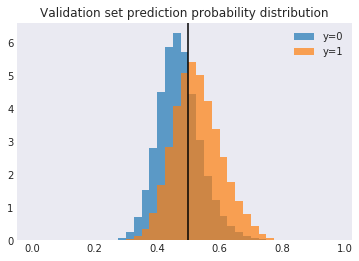

In [116]:
bins = np.arange(0, 1, 0.025)
plt.hist(prob_class0, bins=bins, density=True, alpha=0.7, label="y=0")
plt.hist(prob_class1, bins=bins, density=True, alpha=0.7, label="y=1")
plt.axvline(x=0.5, color='k')
plt.title("Validation set prediction probability distribution")
plt.legend()
plt.show()

### Plot confusion matrix

In [192]:
def plot_cm(cm,title):
    sns.set(font_scale=1.4)
    cm_percent = (cm/cm.sum())*100
    labels = np.array([[str(np.round(x[0],2))+"%",str(np.round(x[1],2))+"%"] for x in (cm/cm.sum())*100])
    ax = sns.heatmap(cm_percent, annot=labels, fmt="")
    ax.set(xlabel='Prediction', ylabel='Truth', title=title)

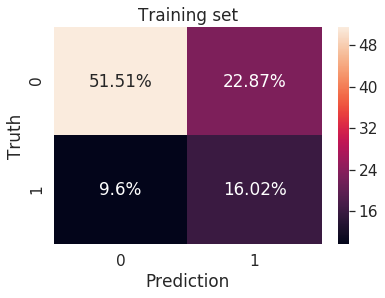

In [193]:
plot_cm(trainResultDict["cm"],"Training set")

In [ ]:
plot_cm(validResultDict["cm"],"Validation set")

### Threshold

In [82]:
trainingSummary = lr_model.summary
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']).select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)

LogisticRegression_4a8f9e8006a8f96c5349

In [83]:
bestThreshold

0.49574921218964213

In [198]:
validPredsAndLabels = lr_model.transform(validDF, {lr_model.threshold: bestThreshold})

In [199]:
predictionRDD = validPredsAndLabels.select(['y', 'prediction']).rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(predictionRDD)
cm = metrics.confusionMatrix().toArray()

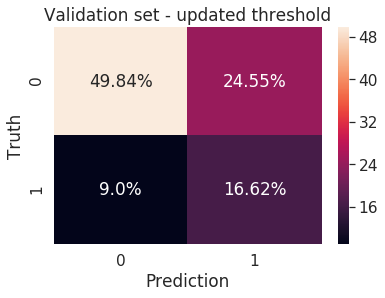

In [200]:
plot_cm(cm,"Validation set - updated threshold")

https://spark.apache.org/docs/2.3.0/ml-classification-regression.html#binomial-logistic-regression

# ---- END ----